In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import torch
import torch.optim as optim
from diffusers.schedulers import DDPMScheduler
from torch.utils.data import TensorDataset, DataLoader, random_split



from dutils import visualize_image, GenerateImages, Rate, set_seed
from nn import AE, SimulationREBECAModel
from sampling import sample_latents_from_prior
from train import train_autoencoder, train_rebeca_prior
from plotting import plot_latents_umap_hearts, plot_user_latent_preferences, plot_real_vs_generated_by_preference, plot_generated_images_on_umap, plot_user_latent_preferences_with_kde

import matplotlib.pyplot as plt
import umap

In [3]:
dataset_zip = np.load('../data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='latin1')

imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']


# use only scale = 1
imgs_noscale = imgs[latents_values[:,2] == 1.0]
latents_values_noscale = latents_values[latents_values[:,2] == 1.0]
latent_classes_noscale = latents_classes[latents_values[:,2] == 1.0]

S = torch.tensor(latents_values_noscale[:,1]-1).long()
X = torch.tensor(imgs_noscale).float()

#shapes_range = ['square', 'ellipse', 'heart']
#colors_range = ['white','red','green','blue']

In [4]:
shapes_range = ['heart', 'square']
colors_range = ['red','blue']

n = 10000
seed = 0

In [5]:
user_profiles = {}
I = [] 
shapes = []
colors = []

id = 0
for shape in shapes_range:
    for color in colors_range:
        user_profiles[id] = {'shape':shape, 'color':color}
        I_temp, shapes_temp, colors_temp = GenerateImages(shape, color, n, X, S, seed=0)
        I.append(I_temp)
        shapes+=shapes_temp
        colors+=colors_temp
        id += 1

I = torch.vstack(I)

np.random.seed(seed)
random_idx = np.random.choice(I.shape[0],I.shape[0],replace=False)
I = I[random_idx]
shapes = np.array(shapes)[random_idx].tolist()
colors = np.array(colors)[random_idx].tolist()

R = torch.zeros((I.shape[0],len(user_profiles.keys())))
for id in user_profiles.keys():
    R[:,id] = Rate(user_profiles[id]['shape'], user_profiles[id]['color'], shapes, colors, ps = [.01, .10, .95])

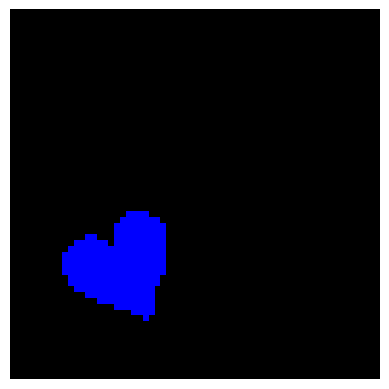

In [6]:
i = 5
visualize_image(I[i])

In [7]:
set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dsprites_dataset = TensorDataset(I)
# Assume dsprites_dataset is already created
total_size = len(dsprites_dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size

train_set, val_set = random_split(dsprites_dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=(device.type == 'cuda'))
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, pin_memory=(device.type == 'cuda'))

Epoch 250/250: 100%|██████████| 250/250 [14:02<00:00,  3.37s/it, train_loss=0.0010, val_loss=0.0019]


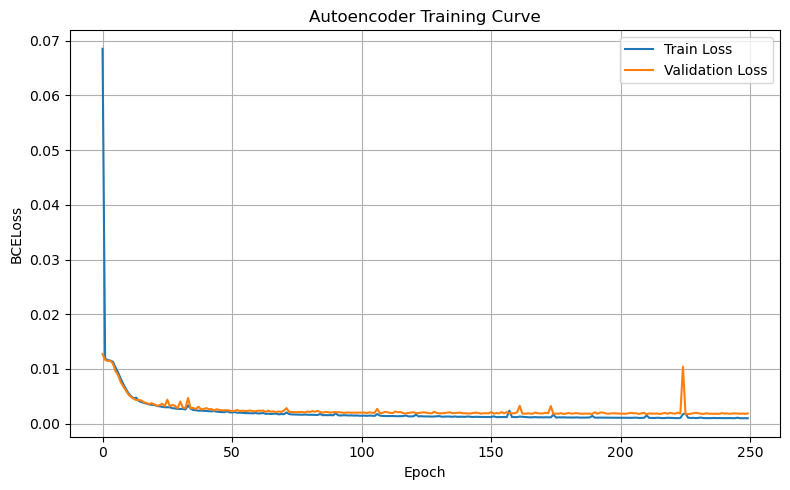

([0.0685314328852627,
  0.01188385225335757,
  0.011609067814217673,
  0.011515699176324739,
  0.011311264894074864,
  0.01029194996919897,
  0.009352666921913624,
  0.008230288225743506,
  0.007249748302002748,
  0.006355499813540114,
  0.005564832983745469,
  0.0050099339443776345,
  0.004640429601073265,
  0.004735581369035774,
  0.004141372505161498,
  0.00392677789595392,
  0.0037883441427515614,
  0.0036471731853153972,
  0.003505703688081768,
  0.0034325168223844635,
  0.0034142825957387685,
  0.0032210621726181774,
  0.0031541829922546944,
  0.003064470646282037,
  0.002992421673817767,
  0.002997700638241238,
  0.0029717688432170284,
  0.0028166361844374076,
  0.0027708424497395754,
  0.0026829774501836963,
  0.0026789649865693516,
  0.0026795088003079095,
  0.0025865054958396486,
  0.003344445084532102,
  0.0027426157080464894,
  0.0024733136635687616,
  0.002455686716362834,
  0.0023603968552003305,
  0.00236703521054652,
  0.002331721526467138,
  0.0022946147993206977,
  0.

In [30]:
autoencoder_model = AE(
    image_size=64,
    in_channels=3,
    latent_dim=8
)

optimizer = optim.Adam(autoencoder_model.parameters(), lr=1e-3)
train_autoencoder(autoencoder_model, train_loader, val_loader, optimizer, device, num_epochs=250)

Epoch 250/250: 100%|██████████| 250/250 [14:10<00:00,  3.40s/it, train_loss=0.0019, val_loss=0.0009]


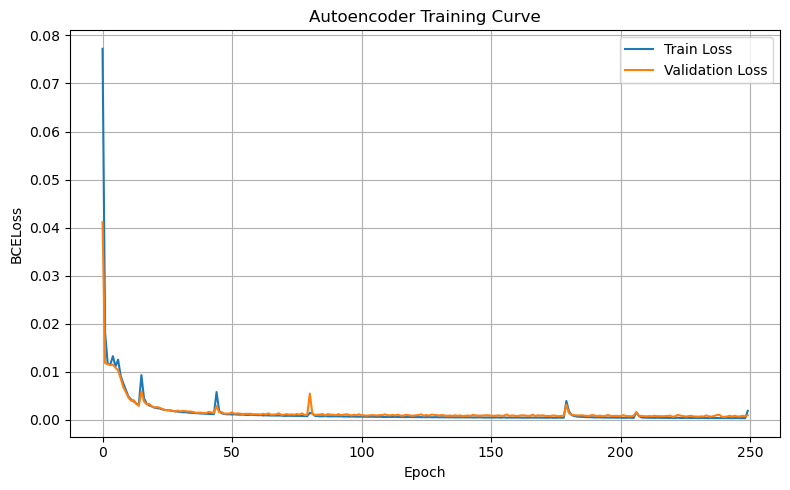

([0.0772198295460807,
  0.01806892496512996,
  0.011645036437445216,
  0.011517604754202895,
  0.013246793461342653,
  0.011110530954268243,
  0.012535873142381509,
  0.009133391208118862,
  0.007599156061394347,
  0.006218332871380779,
  0.004861187419957585,
  0.004239399637199111,
  0.0038594560002287227,
  0.0034171610785027344,
  0.0031381258999721873,
  0.009316235502147012,
  0.004506521198898554,
  0.00341787568707433,
  0.0030027314792904587,
  0.0027653930907448132,
  0.002549674825949801,
  0.0024399662593172656,
  0.0023712582058376735,
  0.0021935959663242103,
  0.0020635259459829995,
  0.0020121392506278223,
  0.001936235717083845,
  0.001863618687312636,
  0.0017731565260845753,
  0.0017151724766525957,
  0.0016287858434435394,
  0.0015815093660106261,
  0.0015853942748573092,
  0.001508637941752871,
  0.0014657972786161634,
  0.001447511900216341,
  0.0013881735164258215,
  0.0013664642710031734,
  0.0013177859950810672,
  0.0012940821207852828,
  0.0012802328635007144,

In [ ]:
autoencoder_ld16_model = AE(
    image_size=64,
    in_channels=3,
    latent_dim=16
)

optimizer = optim.Adam(autoencoder_ld16_model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dsprites_dataset = TensorDataset(I)


train_autoencoder(autoencoder_ld16_model,  train_loader, val_loader, optimizer, device, num_epochs=250)
torch.save(autoencoder_ld16_model.state_dict(), "./autencoder_ld16_wts.pt")

In [8]:
device = "cuda"

autoencoder_ld16_model = autoencoder_ld16_model = AE(
    image_size=64,
    in_channels=3,
    latent_dim=16
).to(device)

autoencoder_ld16_model.load_state_dict(torch.load( "./autencoder_ld16_wts.pt", weights_only=True))
autoencoder_ld16_model.eval()

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (latent_head): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
  (fc_dec): Linear(in_features=16, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7)

In [9]:
dataloader = DataLoader(dsprites_dataset, batch_size=64, shuffle=False)
encoded_images = []
with torch.no_grad():
    for batch in dataloader:
        
        enc_batch = autoencoder_ld16_model.encode(batch[0].to(device)).cpu()
        encoded_images.append(enc_batch)

encoded_image_stack = torch.vstack(encoded_images)
torch.save(encoded_image_stack, "./enc_imgs.pt")

In [10]:
encoded_image_stack = torch.load("./enc_imgs.pt")

In [11]:
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(encoded_image_stack.numpy())

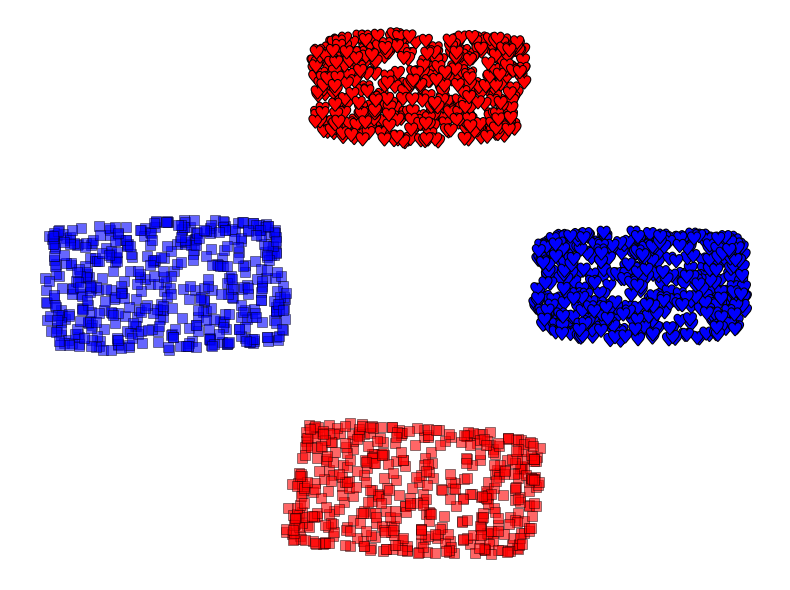

In [12]:
plot_latents_umap_hearts(X_umap, shapes, colors, max_per_group=500, save_path="../figures/ae_ld116_umap.pdf")


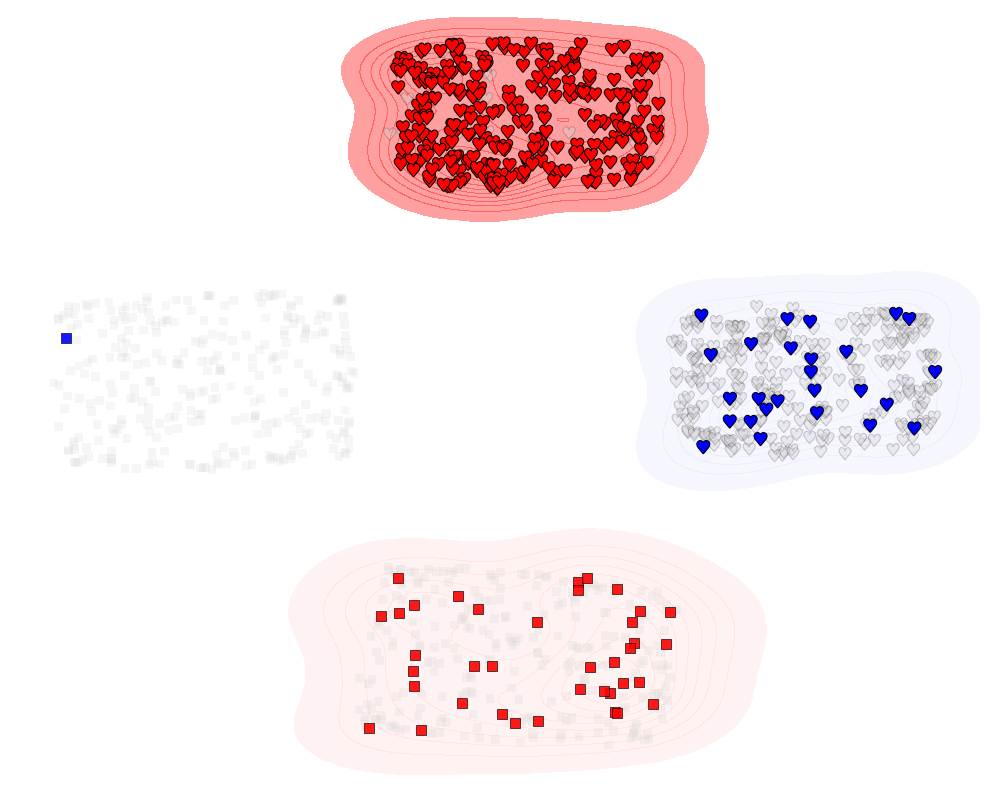

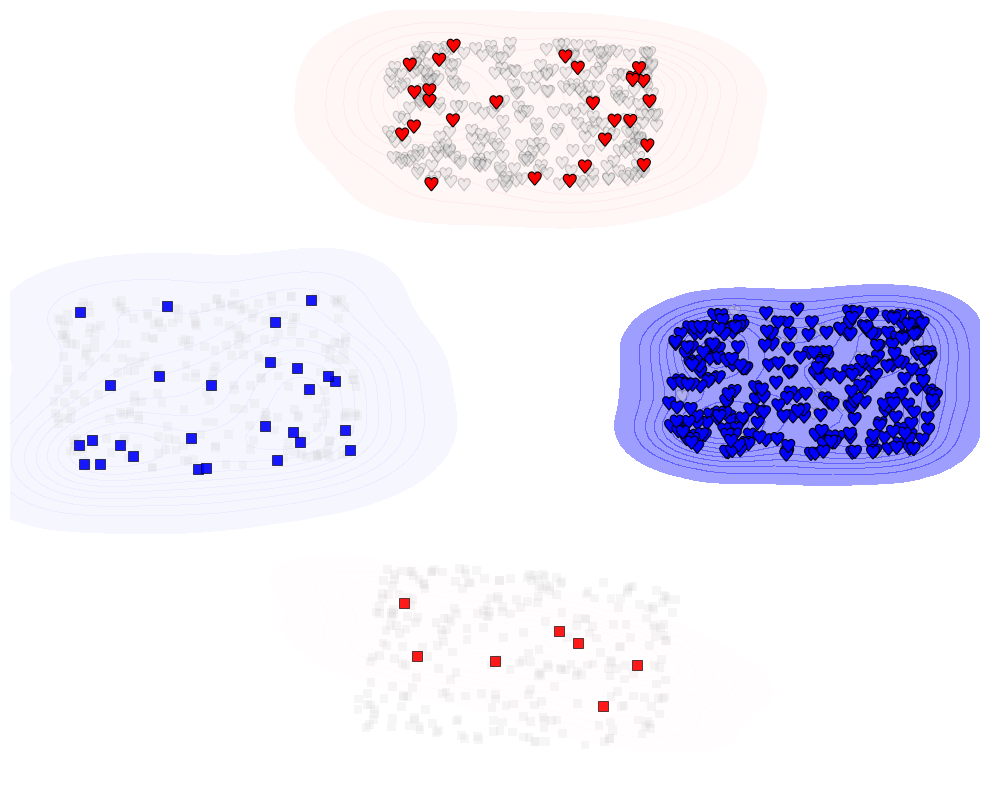

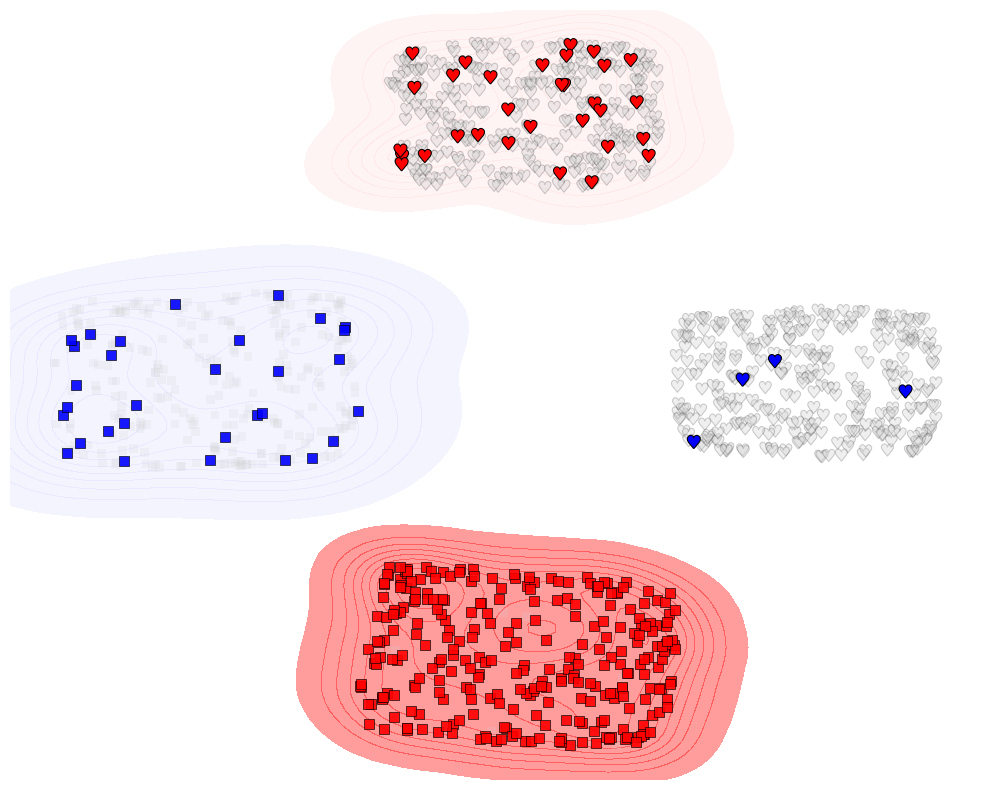

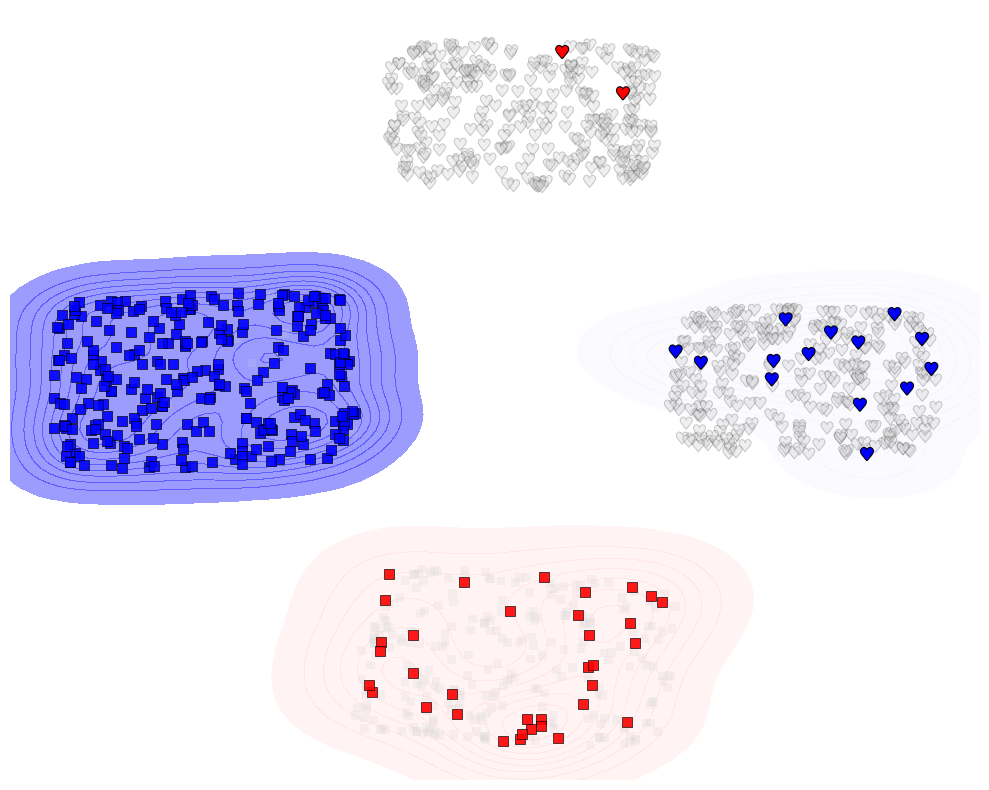

In [13]:
np.random.seed(0)
for user_id in [0,1,2,3]:
    plot_user_latent_preferences_with_kde(X_umap, shapes, colors, R.numpy(), user_idx=user_id, save_path=f"../figures/likes_user{user_id}.pdf")


square
blue
tensor([0., 0., 0., 1.])
{0: {'shape': 'heart', 'color': 'red'}, 1: {'shape': 'heart', 'color': 'blue'}, 2: {'shape': 'square', 'color': 'red'}, 3: {'shape': 'square', 'color': 'blue'}}


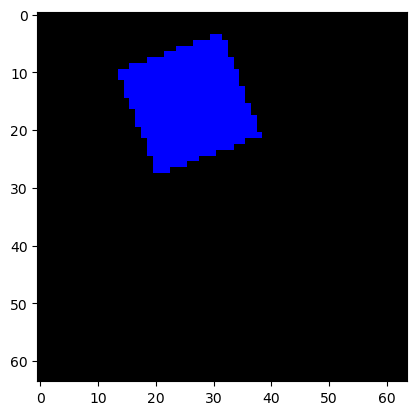

In [14]:
i = 9
plt.imshow(I[i].permute(2,1,0))
print(shapes[i])
print(colors[i])
print(R[i])
print(user_profiles)

## Train REBECA Prior

We train REBECA Priors with $(I_e, U, R)$

In [15]:
set_seed(42)

In [16]:
likes = [R[:, i].reshape(-1, 1) for i in range(R.size(1))]
likes_tensor = torch.vstack(likes)
user_tensor = torch.cat([torch.tensor([i]).repeat( R.size(0)) for i in range(R.size(1))]).unsqueeze(1)
image_embs = encoded_image_stack.repeat(4,1)
diffusion_tensor = torch.cat([image_embs, likes_tensor, user_tensor], dim=1)

In [141]:
encoded_image_stack.shape

torch.Size([40000, 16])

In [17]:
selected_indexes = torch.randperm(len(diffusion_tensor))<(0.9*len(diffusion_tensor))
diffusion_tensor_train = diffusion_tensor[selected_indexes]
diffusion_tensor_test = diffusion_tensor[~selected_indexes]

In [143]:
diffusion_tensor.shape

torch.Size([160000, 18])

In [18]:
rebeca_prior =  SimulationREBECAModel(
    img_embed_dim=image_embs.size(1),
    num_users=4,
    user_embed_dim=16,
    time_dim=100,
    score_dim=16,
    hidden_dim=512,
    num_res_blocks=2
).to(device)

In [19]:
diffusion_dataset = TensorDataset(diffusion_tensor_train)
diffusion_trainloader = DataLoader(diffusion_dataset, batch_size=64, shuffle=True)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="laplace", clip_sample=False)
diffusion_optimizer = torch.optim.AdamW(rebeca_prior.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(diffusion_optimizer, 'min', patience=5, factor=0.5)

In [37]:
train_rebeca_prior(
    model=rebeca_prior,
    trainloader=diffusion_trainloader,
    optimizer=diffusion_optimizer,
    noise_scheduler=noise_scheduler,
    scheduler=scheduler,
    device=device,
    num_epochs=125
)


torch.save(rebeca_prior.state_dict(), "./simulation_rebeca_prior.pt")

Epoch 1/125: 100%|██████████| 2250/2250 [00:09<00:00, 242.01it/s, loss=0.311]


Epoch 1/125 - avg loss: 0.3422


Epoch 2/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.90it/s, loss=0.322]


Epoch 2/125 - avg loss: 0.2989


Epoch 3/125: 100%|██████████| 2250/2250 [00:09<00:00, 231.87it/s, loss=0.311]


Epoch 3/125 - avg loss: 0.2907


Epoch 4/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.30it/s, loss=0.289]


Epoch 4/125 - avg loss: 0.2872


Epoch 5/125: 100%|██████████| 2250/2250 [00:09<00:00, 246.21it/s, loss=0.273]


Epoch 5/125 - avg loss: 0.2843


Epoch 6/125: 100%|██████████| 2250/2250 [00:09<00:00, 248.20it/s, loss=0.295]


Epoch 6/125 - avg loss: 0.2822


Epoch 7/125: 100%|██████████| 2250/2250 [00:08<00:00, 251.95it/s, loss=0.275]


Epoch 7/125 - avg loss: 0.2805


Epoch 8/125: 100%|██████████| 2250/2250 [00:09<00:00, 242.91it/s, loss=0.269]


Epoch 8/125 - avg loss: 0.2783


Epoch 9/125: 100%|██████████| 2250/2250 [00:09<00:00, 226.18it/s, loss=0.25] 


Epoch 9/125 - avg loss: 0.2774


Epoch 10/125: 100%|██████████| 2250/2250 [00:09<00:00, 228.19it/s, loss=0.232]


Epoch 10/125 - avg loss: 0.2758


Epoch 11/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.61it/s, loss=0.306]


Epoch 11/125 - avg loss: 0.2755


Epoch 12/125: 100%|██████████| 2250/2250 [00:09<00:00, 228.66it/s, loss=0.26] 


Epoch 12/125 - avg loss: 0.2754


Epoch 13/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.03it/s, loss=0.26] 


Epoch 13/125 - avg loss: 0.2746


Epoch 14/125: 100%|██████████| 2250/2250 [00:09<00:00, 227.86it/s, loss=0.249]


Epoch 14/125 - avg loss: 0.2728


Epoch 15/125: 100%|██████████| 2250/2250 [00:10<00:00, 223.44it/s, loss=0.297]


Epoch 15/125 - avg loss: 0.2726


Epoch 16/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.36it/s, loss=0.294]


Epoch 16/125 - avg loss: 0.2717


Epoch 17/125: 100%|██████████| 2250/2250 [00:10<00:00, 217.62it/s, loss=0.256]


Epoch 17/125 - avg loss: 0.2716


Epoch 18/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.96it/s, loss=0.286]


Epoch 18/125 - avg loss: 0.2708


Epoch 19/125: 100%|██████████| 2250/2250 [00:09<00:00, 225.44it/s, loss=0.25] 


Epoch 19/125 - avg loss: 0.2702


Epoch 20/125: 100%|██████████| 2250/2250 [00:10<00:00, 221.36it/s, loss=0.244]


Epoch 20/125 - avg loss: 0.2697


Epoch 21/125: 100%|██████████| 2250/2250 [00:10<00:00, 214.09it/s, loss=0.283]


Epoch 21/125 - avg loss: 0.2693


Epoch 22/125: 100%|██████████| 2250/2250 [00:09<00:00, 235.38it/s, loss=0.256]


Epoch 22/125 - avg loss: 0.2690


Epoch 23/125: 100%|██████████| 2250/2250 [00:09<00:00, 227.14it/s, loss=0.212]


Epoch 23/125 - avg loss: 0.2681


Epoch 24/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.22it/s, loss=0.276]


Epoch 24/125 - avg loss: 0.2680


Epoch 25/125: 100%|██████████| 2250/2250 [00:10<00:00, 212.24it/s, loss=0.264]


Epoch 25/125 - avg loss: 0.2676


Epoch 26/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.93it/s, loss=0.27] 


Epoch 26/125 - avg loss: 0.2667


Epoch 27/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.34it/s, loss=0.257]


Epoch 27/125 - avg loss: 0.2670


Epoch 28/125: 100%|██████████| 2250/2250 [00:10<00:00, 221.30it/s, loss=0.268]


Epoch 28/125 - avg loss: 0.2661


Epoch 29/125: 100%|██████████| 2250/2250 [00:09<00:00, 231.33it/s, loss=0.24] 


Epoch 29/125 - avg loss: 0.2658


Epoch 30/125: 100%|██████████| 2250/2250 [00:10<00:00, 220.23it/s, loss=0.236]


Epoch 30/125 - avg loss: 0.2663


Epoch 31/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.38it/s, loss=0.221]


Epoch 31/125 - avg loss: 0.2647


Epoch 32/125: 100%|██████████| 2250/2250 [00:10<00:00, 221.83it/s, loss=0.268]


Epoch 32/125 - avg loss: 0.2643


Epoch 33/125: 100%|██████████| 2250/2250 [00:10<00:00, 211.26it/s, loss=0.27] 


Epoch 33/125 - avg loss: 0.2644


Epoch 34/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.71it/s, loss=0.255]


Epoch 34/125 - avg loss: 0.2638


Epoch 35/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.74it/s, loss=0.287]


Epoch 35/125 - avg loss: 0.2634


Epoch 36/125: 100%|██████████| 2250/2250 [00:10<00:00, 220.87it/s, loss=0.265]


Epoch 36/125 - avg loss: 0.2624


Epoch 37/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.78it/s, loss=0.293]


Epoch 37/125 - avg loss: 0.2633


Epoch 38/125: 100%|██████████| 2250/2250 [00:10<00:00, 209.65it/s, loss=0.319]


Epoch 38/125 - avg loss: 0.2629


Epoch 39/125: 100%|██████████| 2250/2250 [00:10<00:00, 215.35it/s, loss=0.317]


Epoch 39/125 - avg loss: 0.2620


Epoch 40/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.37it/s, loss=0.254]


Epoch 40/125 - avg loss: 0.2621


Epoch 41/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.54it/s, loss=0.255]


Epoch 41/125 - avg loss: 0.2622


Epoch 42/125: 100%|██████████| 2250/2250 [00:09<00:00, 231.69it/s, loss=0.275]


Epoch 42/125 - avg loss: 0.2621


Epoch 43/125: 100%|██████████| 2250/2250 [00:09<00:00, 233.82it/s, loss=0.222]


Epoch 43/125 - avg loss: 0.2617


Epoch 44/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.04it/s, loss=0.279]


Epoch 44/125 - avg loss: 0.2616


Epoch 45/125: 100%|██████████| 2250/2250 [00:10<00:00, 216.11it/s, loss=0.253]


Epoch 45/125 - avg loss: 0.2615


Epoch 46/125: 100%|██████████| 2250/2250 [00:10<00:00, 206.31it/s, loss=0.277]


Epoch 46/125 - avg loss: 0.2598


Epoch 47/125: 100%|██████████| 2250/2250 [00:10<00:00, 220.38it/s, loss=0.304]


Epoch 47/125 - avg loss: 0.2612


Epoch 48/125: 100%|██████████| 2250/2250 [00:10<00:00, 223.50it/s, loss=0.293]


Epoch 48/125 - avg loss: 0.2611


Epoch 49/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.98it/s, loss=0.272]


Epoch 49/125 - avg loss: 0.2601


Epoch 50/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.60it/s, loss=0.283]


Epoch 50/125 - avg loss: 0.2604


Epoch 51/125: 100%|██████████| 2250/2250 [00:09<00:00, 228.93it/s, loss=0.244]


Epoch 51/125 - avg loss: 0.2605


Epoch 52/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.53it/s, loss=0.276]


Epoch 52/125 - avg loss: 0.2600


Epoch 53/125: 100%|██████████| 2250/2250 [00:10<00:00, 221.01it/s, loss=0.258]


Epoch 53/125 - avg loss: 0.2576


Epoch 54/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.44it/s, loss=0.263]


Epoch 54/125 - avg loss: 0.2568


Epoch 55/125: 100%|██████████| 2250/2250 [00:09<00:00, 225.94it/s, loss=0.264]


Epoch 55/125 - avg loss: 0.2576


Epoch 56/125: 100%|██████████| 2250/2250 [00:09<00:00, 226.19it/s, loss=0.241]


Epoch 56/125 - avg loss: 0.2576


Epoch 57/125: 100%|██████████| 2250/2250 [00:09<00:00, 242.80it/s, loss=0.206]


Epoch 57/125 - avg loss: 0.2563


Epoch 58/125: 100%|██████████| 2250/2250 [00:08<00:00, 255.00it/s, loss=0.232]


Epoch 58/125 - avg loss: 0.2568


Epoch 59/125: 100%|██████████| 2250/2250 [00:08<00:00, 257.79it/s, loss=0.245]


Epoch 59/125 - avg loss: 0.2562


Epoch 60/125: 100%|██████████| 2250/2250 [00:08<00:00, 257.51it/s, loss=0.286]


Epoch 60/125 - avg loss: 0.2564


Epoch 61/125: 100%|██████████| 2250/2250 [00:08<00:00, 253.88it/s, loss=0.275]


Epoch 61/125 - avg loss: 0.2563


Epoch 62/125: 100%|██████████| 2250/2250 [00:08<00:00, 251.01it/s, loss=0.258]


Epoch 62/125 - avg loss: 0.2563


Epoch 63/125: 100%|██████████| 2250/2250 [00:09<00:00, 247.78it/s, loss=0.238]


Epoch 63/125 - avg loss: 0.2560


Epoch 64/125: 100%|██████████| 2250/2250 [00:09<00:00, 238.42it/s, loss=0.261]


Epoch 64/125 - avg loss: 0.2563


Epoch 65/125: 100%|██████████| 2250/2250 [00:09<00:00, 241.80it/s, loss=0.266]


Epoch 65/125 - avg loss: 0.2549


Epoch 66/125: 100%|██████████| 2250/2250 [00:09<00:00, 233.48it/s, loss=0.264]


Epoch 66/125 - avg loss: 0.2562


Epoch 67/125: 100%|██████████| 2250/2250 [00:09<00:00, 236.61it/s, loss=0.265]


Epoch 67/125 - avg loss: 0.2563


Epoch 68/125: 100%|██████████| 2250/2250 [00:09<00:00, 237.09it/s, loss=0.226]


Epoch 68/125 - avg loss: 0.2563


Epoch 69/125: 100%|██████████| 2250/2250 [00:09<00:00, 239.33it/s, loss=0.29] 


Epoch 69/125 - avg loss: 0.2565


Epoch 70/125: 100%|██████████| 2250/2250 [00:09<00:00, 237.85it/s, loss=0.253]


Epoch 70/125 - avg loss: 0.2557


Epoch 71/125: 100%|██████████| 2250/2250 [00:09<00:00, 246.82it/s, loss=0.264]


Epoch 71/125 - avg loss: 0.2556


Epoch 72/125: 100%|██████████| 2250/2250 [00:09<00:00, 247.43it/s, loss=0.265]


Epoch 72/125 - avg loss: 0.2548


Epoch 73/125: 100%|██████████| 2250/2250 [00:09<00:00, 244.46it/s, loss=0.237]


Epoch 73/125 - avg loss: 0.2550


Epoch 74/125: 100%|██████████| 2250/2250 [00:09<00:00, 242.46it/s, loss=0.257]


Epoch 74/125 - avg loss: 0.2550


Epoch 75/125: 100%|██████████| 2250/2250 [00:09<00:00, 244.08it/s, loss=0.241]


Epoch 75/125 - avg loss: 0.2554


Epoch 76/125: 100%|██████████| 2250/2250 [00:09<00:00, 246.57it/s, loss=0.259]


Epoch 76/125 - avg loss: 0.2541


Epoch 77/125: 100%|██████████| 2250/2250 [00:09<00:00, 240.14it/s, loss=0.216]


Epoch 77/125 - avg loss: 0.2543


Epoch 78/125: 100%|██████████| 2250/2250 [00:09<00:00, 242.66it/s, loss=0.236]


Epoch 78/125 - avg loss: 0.2543


Epoch 79/125: 100%|██████████| 2250/2250 [00:09<00:00, 241.94it/s, loss=0.216]


Epoch 79/125 - avg loss: 0.2547


Epoch 80/125: 100%|██████████| 2250/2250 [00:09<00:00, 244.25it/s, loss=0.275]


Epoch 80/125 - avg loss: 0.2539


Epoch 81/125: 100%|██████████| 2250/2250 [00:09<00:00, 243.31it/s, loss=0.289]


Epoch 81/125 - avg loss: 0.2542


Epoch 82/125: 100%|██████████| 2250/2250 [00:09<00:00, 248.00it/s, loss=0.237]


Epoch 82/125 - avg loss: 0.2535


Epoch 83/125: 100%|██████████| 2250/2250 [00:09<00:00, 246.49it/s, loss=0.253]


Epoch 83/125 - avg loss: 0.2545


Epoch 84/125: 100%|██████████| 2250/2250 [00:09<00:00, 248.99it/s, loss=0.26] 


Epoch 84/125 - avg loss: 0.2542


Epoch 85/125: 100%|██████████| 2250/2250 [00:09<00:00, 247.34it/s, loss=0.259]


Epoch 85/125 - avg loss: 0.2546


Epoch 86/125: 100%|██████████| 2250/2250 [00:09<00:00, 246.30it/s, loss=0.255]


Epoch 86/125 - avg loss: 0.2545


Epoch 87/125: 100%|██████████| 2250/2250 [00:09<00:00, 240.63it/s, loss=0.271]


Epoch 87/125 - avg loss: 0.2546


Epoch 88/125: 100%|██████████| 2250/2250 [00:09<00:00, 232.71it/s, loss=0.285]


Epoch 88/125 - avg loss: 0.2535


Epoch 89/125: 100%|██████████| 2250/2250 [00:11<00:00, 201.04it/s, loss=0.255]


Epoch 89/125 - avg loss: 0.2539


Epoch 90/125: 100%|██████████| 2250/2250 [00:10<00:00, 213.65it/s, loss=0.246]


Epoch 90/125 - avg loss: 0.2538


Epoch 91/125: 100%|██████████| 2250/2250 [00:10<00:00, 209.36it/s, loss=0.306]


Epoch 91/125 - avg loss: 0.2533


Epoch 92/125: 100%|██████████| 2250/2250 [00:10<00:00, 223.73it/s, loss=0.252]


Epoch 92/125 - avg loss: 0.2538


Epoch 93/125: 100%|██████████| 2250/2250 [00:09<00:00, 225.05it/s, loss=0.26] 


Epoch 93/125 - avg loss: 0.2526


Epoch 94/125: 100%|██████████| 2250/2250 [00:10<00:00, 214.48it/s, loss=0.274]


Epoch 94/125 - avg loss: 0.2535


Epoch 95/125: 100%|██████████| 2250/2250 [00:10<00:00, 215.68it/s, loss=0.289]


Epoch 95/125 - avg loss: 0.2531


Epoch 96/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.90it/s, loss=0.216]


Epoch 96/125 - avg loss: 0.2539


Epoch 97/125: 100%|██████████| 2250/2250 [00:10<00:00, 223.28it/s, loss=0.241]


Epoch 97/125 - avg loss: 0.2525


Epoch 98/125: 100%|██████████| 2250/2250 [00:09<00:00, 225.71it/s, loss=0.237]


Epoch 98/125 - avg loss: 0.2531


Epoch 99/125: 100%|██████████| 2250/2250 [00:10<00:00, 214.07it/s, loss=0.263]


Epoch 99/125 - avg loss: 0.2538


Epoch 100/125: 100%|██████████| 2250/2250 [00:10<00:00, 218.87it/s, loss=0.259]


Epoch 100/125 - avg loss: 0.2526


Epoch 101/125: 100%|██████████| 2250/2250 [00:10<00:00, 223.33it/s, loss=0.279]


Epoch 101/125 - avg loss: 0.2526


Epoch 102/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.15it/s, loss=0.252]


Epoch 102/125 - avg loss: 0.2533


Epoch 103/125: 100%|██████████| 2250/2250 [00:10<00:00, 216.09it/s, loss=0.257]


Epoch 103/125 - avg loss: 0.2537


Epoch 104/125: 100%|██████████| 2250/2250 [00:10<00:00, 217.43it/s, loss=0.268]


Epoch 104/125 - avg loss: 0.2530


Epoch 105/125: 100%|██████████| 2250/2250 [00:10<00:00, 219.03it/s, loss=0.226]


Epoch 105/125 - avg loss: 0.2529


Epoch 106/125: 100%|██████████| 2250/2250 [00:10<00:00, 215.31it/s, loss=0.27] 


Epoch 106/125 - avg loss: 0.2521


Epoch 107/125: 100%|██████████| 2250/2250 [00:10<00:00, 210.91it/s, loss=0.282]


Epoch 107/125 - avg loss: 0.2536


Epoch 108/125: 100%|██████████| 2250/2250 [00:09<00:00, 226.69it/s, loss=0.26] 


Epoch 108/125 - avg loss: 0.2529


Epoch 109/125: 100%|██████████| 2250/2250 [00:10<00:00, 209.33it/s, loss=0.256]


Epoch 109/125 - avg loss: 0.2524


Epoch 110/125: 100%|██████████| 2250/2250 [00:10<00:00, 213.97it/s, loss=0.235]


Epoch 110/125 - avg loss: 0.2529


Epoch 111/125: 100%|██████████| 2250/2250 [00:11<00:00, 191.60it/s, loss=0.22] 


Epoch 111/125 - avg loss: 0.2527


Epoch 112/125: 100%|██████████| 2250/2250 [00:10<00:00, 219.51it/s, loss=0.219]


Epoch 112/125 - avg loss: 0.2530


Epoch 113/125: 100%|██████████| 2250/2250 [00:10<00:00, 216.81it/s, loss=0.246]


Epoch 113/125 - avg loss: 0.2525


Epoch 114/125: 100%|██████████| 2250/2250 [00:10<00:00, 219.96it/s, loss=0.277]


Epoch 114/125 - avg loss: 0.2529


Epoch 115/125: 100%|██████████| 2250/2250 [00:10<00:00, 212.64it/s, loss=0.25] 


Epoch 115/125 - avg loss: 0.2527


Epoch 116/125: 100%|██████████| 2250/2250 [00:10<00:00, 222.35it/s, loss=0.227]


Epoch 116/125 - avg loss: 0.2527


Epoch 117/125: 100%|██████████| 2250/2250 [00:10<00:00, 217.98it/s, loss=0.281]


Epoch 117/125 - avg loss: 0.2529


Epoch 118/125: 100%|██████████| 2250/2250 [00:10<00:00, 215.37it/s, loss=0.253]


Epoch 118/125 - avg loss: 0.2527


Epoch 119/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.61it/s, loss=0.273]


Epoch 119/125 - avg loss: 0.2529


Epoch 120/125: 100%|██████████| 2250/2250 [00:09<00:00, 230.96it/s, loss=0.244]


Epoch 120/125 - avg loss: 0.2528


Epoch 121/125: 100%|██████████| 2250/2250 [00:09<00:00, 233.59it/s, loss=0.23] 


Epoch 121/125 - avg loss: 0.2523


Epoch 122/125: 100%|██████████| 2250/2250 [00:10<00:00, 219.15it/s, loss=0.226]


Epoch 122/125 - avg loss: 0.2533


Epoch 123/125: 100%|██████████| 2250/2250 [00:10<00:00, 224.18it/s, loss=0.255]


Epoch 123/125 - avg loss: 0.2528


Epoch 124/125: 100%|██████████| 2250/2250 [00:09<00:00, 225.73it/s, loss=0.253]


Epoch 124/125 - avg loss: 0.2532


Epoch 125/125: 100%|██████████| 2250/2250 [00:10<00:00, 217.24it/s, loss=0.248]

Epoch 125/125 - avg loss: 0.2516


In [20]:
rebeca_prior =  SimulationREBECAModel(
    img_embed_dim=16,
    num_users=4,
    user_embed_dim=16,
    time_dim=100,
    score_dim=16,
    hidden_dim=512,
    num_res_blocks=2
).to(device)


rebeca_prior.load_state_dict(torch.load( "./simulation_rebeca_prior.pt", weights_only=True))
rebeca_prior.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="laplace", clip_sample=False)

In [96]:
def compute_precision_recall_at_k(
    generated,  # (n, latent_dim)
    encoded_real,  # (N, latent_dim)
    R,  # (N, num_users)
    user_id,
    top_k=1
):
    from sklearn.metrics.pairwise import cosine_similarity
    sims = cosine_similarity(generated.cpu().numpy(), encoded_real.cpu().numpy())  # (n, N)
    topk_indices = sims.argsort(axis=1)[:, -top_k:]  # (N, n)
    recommended_items = np.unique(topk_indices.flatten())
    liked_items = np.where(R == 1)[0]
    relevant_retrieved = np.intersect1d(recommended_items, liked_items)
    precision = len(relevant_retrieved) / len(recommended_items)
    recall = len(relevant_retrieved) / len(liked_items)
    return precision, recall


def compute_wasserstein_distance(generated, liked_embs):
    M = ot.dist(generated, liked_embs, metric='sqeuclidean')  
    a = np.ones((generated.shape[0],)) / generated.shape[0]
    b = np.ones((liked_embs.shape[0],)) / liked_embs.shape[0]
    return emd2(a, b, M, numItermax=1000000)

In [22]:
with torch.no_grad():
    embs = sample_latents_from_prior(
            model=rebeca_prior,
            noise_scheduler=noise_scheduler,
            user_id=0,
            score=1,
            latent_dim=16,
            num_samples=1,
            device=device
                )

In [118]:
encoded_image_test.shape

torch.Size([16000, 16])

In [125]:
set_seed(0)
from sampling import sample_latents_from_prior
from tqdm import tqdm

user_stats = dict.fromkeys([0, 1, 2, 3])
rebeca_prior.eval()
encoded_image_test = diffusion_tensor_test[:,:16]
encoded_image_train = diffusion_tensor_train[:,:16]
n_experiments = 100
experiments = []

for n_experiments in tqdm(range(n_experiments)):
    user_stats = {}
    for user_id in [0, 1, 2, 3]:
        # We check that the diffusion_tensor test has the right user, then take the likes collumn (-2)
        encoded_test = diffusion_tensor_test[diffusion_tensor_test[:,-1] == user_id][:,:16]
        R_test = diffusion_tensor_test[diffusion_tensor_test[:,-1] == user_id][:,-2]

        liked = encoded_image_stack[R[:, user_id] == 1].cpu().numpy()
        mean_embedding = liked.mean(axis=0, keepdims=True)
        
        k_stats = {"precision":[], "recall":[]}
        rand_stats = {"precision": [], "recall": []}
        mean_stats = {"precision": [], "recall": []}

        for k in [1, 5, 10, 20, 25]:
            with torch.no_grad():
                embs = sample_latents_from_prior(
                    model=rebeca_prior,
                    noise_scheduler=noise_scheduler,
                    user_id=user_id,
                    score=1,
                    latent_dim=16,
                    num_samples=k,
                    device=device
                )
            precision, recall = compute_precision_recall_at_k(
                                embs.detach(),
                                encoded_real=encoded_test,
                                R=R_test.numpy(),
                                user_id=user_id,
                                top_k=1)
            k_stats["precision"].append(precision)
            k_stats["recall"].append(recall)

            ### Mean stats per k
            mean_generated = np.repeat(mean_embedding, k, axis=0)
            
            p, r = compute_precision_recall_at_k(
                torch.tensor(mean_generated),
                encoded_real=encoded_test,
                R=R_test.numpy(),
                user_id=user_id,
                top_k=1
                )
            mean_stats["precision"].append(p)
            mean_stats["recall"].append(r)

            # Random baseline
            rand_generated = encoded_image_train[torch.randint(0, len(encoded_image_train), (k,))].cpu().numpy()
            
            p, r = compute_precision_recall_at_k(
                    torch.tensor(rand_generated),
                    encoded_real=encoded_test,
                    R=R_test.numpy(),
                    user_id=user_id,
                    top_k=1
                )
            rand_stats["precision"].append(p)
            rand_stats["recall"].append(r)

        user_stats[f"mean_{user_id}"] = mean_stats
        user_stats[f"random_{user_id}"] = rand_stats
        user_stats[f"rebeca_{user_id}"] = k_stats
    experiments.append(user_stats)


100%|██████████| 100/100 [36:08<00:00, 21.68s/it]


In [121]:
ks = [1, 5, 10, 20, 25]
user_ids = [0, 1, 2, 3]


rebeca_results = {"precision": {i:{j:[] for j in ks} for i in user_ids}, "recall":{i:{j:[] for j in ks} for i in user_ids}}
mean_results = {"precision":{i:{j:[] for j in ks} for i in user_ids}, "recall":{i:{j:[] for j in ks} for i in user_ids}}
random_results = {"precision":{i:{j:[] for j in ks} for i in user_ids}, "recall":{i:{j:[] for j in ks} for i in user_ids}}

for user_id in user_ids:
    for ik, k in enumerate(ks):
        for experiment in experiments:
            mean_results["precision"][user_id][k].append(experiment[f"mean_{user_id}"]["precision"][ik])
            random_results["precision"][user_id][k].append(experiment[f"random_{user_id}"]["precision"][ik])
            rebeca_results["precision"][user_id][k].append(experiment[f"rebeca_{user_id}"]["precision"][ik])

            mean_results["recall"][user_id][k].append(experiment[f"mean_{user_id}"]["recall"][ik])
            random_results["recall"][user_id][k].append(experiment[f"random_{user_id}"]["recall"][ik])
            rebeca_results["recall"][user_id][k].append(experiment[f"rebeca_{user_id}"]["recall"][ik])

In [122]:
import numpy as np

def summarize_results(results_dict):
    summary = {}
    for metric in ['precision', 'recall']:
        summary[metric] = {}
        for user_id in user_ids:
            summary[metric][user_id] = {}
            for k in ks:
                values = results_dict[metric][user_id][k]
                mean = np.mean(values)
                std = np.std(values)
                stderr = std / np.sqrt(len(values))
                summary[metric][user_id][k] = {'mean': mean, 'stderr': stderr}
    return summary

rebeca_summary = summarize_results(rebeca_results)
random_summary = summarize_results(random_results)
mean_summary = summarize_results(mean_results)


In [135]:
all_results = {
    "rebeca": rebeca_results,
    "mean": mean_results,
    "random": random_results
}

import json

with open("precision_recall_results.json", "w") as f:
    json.dump(all_results, f, indent=4)

In [133]:
print(rebeca_summary["precision"])
print(mean_summary["precision"])
print(random_summary["precision"])

{0: {1: {'mean': 0.9, 'stderr': 0.09486832980505139}, 5: {'mean': 0.82, 'stderr': 0.044271887242357304}, 10: {'mean': 0.7, 'stderr': 0.04690415759823429}, 20: {'mean': 0.755, 'stderr': 0.021737065119284162}, 25: {'mean': 0.7663333333333333, 'stderr': 0.01584087539668605}}, 1: {1: {'mean': 1.0, 'stderr': 0.0}, 5: {'mean': 0.9200000000000002, 'stderr': 0.030983866769659325}, 10: {'mean': 0.8, 'stderr': 0.042426406871192854}, 20: {'mean': 0.7942105263157895, 'stderr': 0.026727826909457846}, 25: {'mean': 0.8160000000000001, 'stderr': 0.018931455305918766}}, 2: {1: {'mean': 0.5, 'stderr': 0.15811388300841897}, 5: {'mean': 0.8200000000000001, 'stderr': 0.0340587727318528}, 10: {'mean': 0.7877777777777777, 'stderr': 0.04110960958218894}, 20: {'mean': 0.7086842105263158, 'stderr': 0.021932438440713308}, 25: {'mean': 0.6759999999999999, 'stderr': 0.019141577782408634}}, 3: {1: {'mean': 0.8, 'stderr': 0.12649110640673517}, 5: {'mean': 0.8, 'stderr': 0.06928203230275509}, 10: {'mean': 0.880000000

In [134]:
print(rebeca_summary["recall"])
print(mean_summary["recall"])
print(random_summary["recall"])

{0: {1: {'mean': 0.0007685738684884714, 'stderr': 8.101479915034276e-05}, 5: {'mean': 0.0035012809564474805, 'stderr': 0.00018903453135079976}, 10: {'mean': 0.005977796754910333, 'stderr': 0.000400547887260754}, 20: {'mean': 0.012894961571306573, 'stderr': 0.00037125644951808973}, 25: {'mean': 0.016225448334756618, 'stderr': 0.000319526676923479}}, 1: {1: {'mean': 0.0008481764206955047, 'stderr': 0.0}, 5: {'mean': 0.0039016115351993216, 'stderr': 0.00013139892607998016}, 10: {'mean': 0.006785411365564037, 'stderr': 0.00035985077922979516}, 20: {'mean': 0.013401187446988974, 'stderr': 0.0004455954380513552}, 25: {'mean': 0.017302798982188294, 'stderr': 0.0004014303499982776}}, 2: {1: {'mean': 0.0004409171075837742, 'stderr': 0.00013943023192982272}, 5: {'mean': 0.003615520282186949, 'stderr': 0.00015017095560781657}, 10: {'mean': 0.006878306878306878, 'stderr': 0.0003699502109947624}, 20: {'mean': 0.012433862433862432, 'stderr': 0.0003833697551901967}, 25: {'mean': 0.01490299823633157, 

In [130]:
mean_summary["precision"]

{0: {1: {'mean': 0.0, 'stderr': 0.0},
  5: {'mean': 0.0, 'stderr': 0.0},
  10: {'mean': 0.0, 'stderr': 0.0},
  20: {'mean': 0.0, 'stderr': 0.0},
  25: {'mean': 0.0, 'stderr': 0.0}},
 1: {1: {'mean': 1.0, 'stderr': 0.0},
  5: {'mean': 1.0, 'stderr': 0.0},
  10: {'mean': 1.0, 'stderr': 0.0},
  20: {'mean': 1.0, 'stderr': 0.0},
  25: {'mean': 1.0, 'stderr': 0.0}},
 2: {1: {'mean': 1.0, 'stderr': 0.0},
  5: {'mean': 1.0, 'stderr': 0.0},
  10: {'mean': 1.0, 'stderr': 0.0},
  20: {'mean': 1.0, 'stderr': 0.0},
  25: {'mean': 1.0, 'stderr': 0.0}},
 3: {1: {'mean': 1.0, 'stderr': 0.0},
  5: {'mean': 1.0, 'stderr': 0.0},
  10: {'mean': 1.0, 'stderr': 0.0},
  20: {'mean': 1.0, 'stderr': 0.0},
  25: {'mean': 1.0, 'stderr': 0.0}}}

In [132]:
random_summary["precision"]

{0: {1: {'mean': 0.1, 'stderr': 0.09486832980505139},
  5: {'mean': 0.24000000000000005, 'stderr': 0.04732863826479692},
  10: {'mean': 0.32999999999999996, 'stderr': 0.049091750834534306},
  20: {'mean': 0.32499999999999996, 'stderr': 0.017677669529663688},
  25: {'mean': 0.27316666666666667, 'stderr': 0.033416936823513106}},
 1: {1: {'mean': 0.4, 'stderr': 0.15491933384829668},
  5: {'mean': 0.4000000000000001, 'stderr': 0.04898979485566356},
  10: {'mean': 0.27, 'stderr': 0.03478505426185217},
  20: {'mean': 0.2613157894736842, 'stderr': 0.028087837097181118},
  25: {'mean': 0.2451666666666667, 'stderr': 0.028142938723594597}},
 2: {1: {'mean': 0.3, 'stderr': 0.14491376746189435},
  5: {'mean': 0.24000000000000005, 'stderr': 0.05513619500836088},
  10: {'mean': 0.26, 'stderr': 0.04732863826479692},
  20: {'mean': 0.27999999999999997, 'stderr': 0.040743097574926716},
  25: {'mean': 0.268, 'stderr': 0.0160499221181911}},
 3: {1: {'mean': 0.0, 'stderr': 0.0},
  5: {'mean': 0.38, 'stder

In [140]:
diffusion_tensor_test[diffusion_tensor_test[:,-1] == 3][:,-2].shape

torch.Size([3948])

In [136]:
encoded_test.shape

torch.Size([3948, 16])

In [56]:
import json
with open("./user_stats.json", 'w') as json_file:
    json.dump(user_stats, json_file, indent=4)

In [36]:
liked = torch.stack([encoded_image_stack[R[:, user_id] == 1].mean(axis=0) for user_id in range(4)]).to(device)
rebeca_decoded_mean = autoencoder_ld16_model.decode(liked).detach().cpu().numpy()

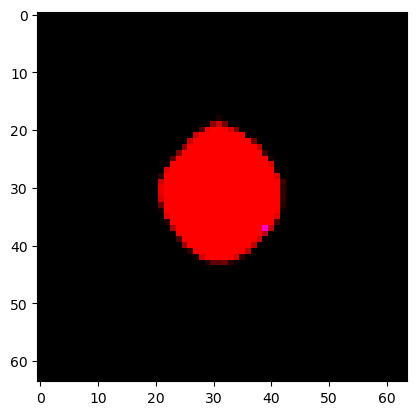

In [37]:
rebeca_mean_user_images = np.einsum('ijkl->ilkj', rebeca_decoded_mean)
plt.imshow(rebeca_mean_user_images[2])

In [23]:
from plotting import plot_combined_kde_and_images

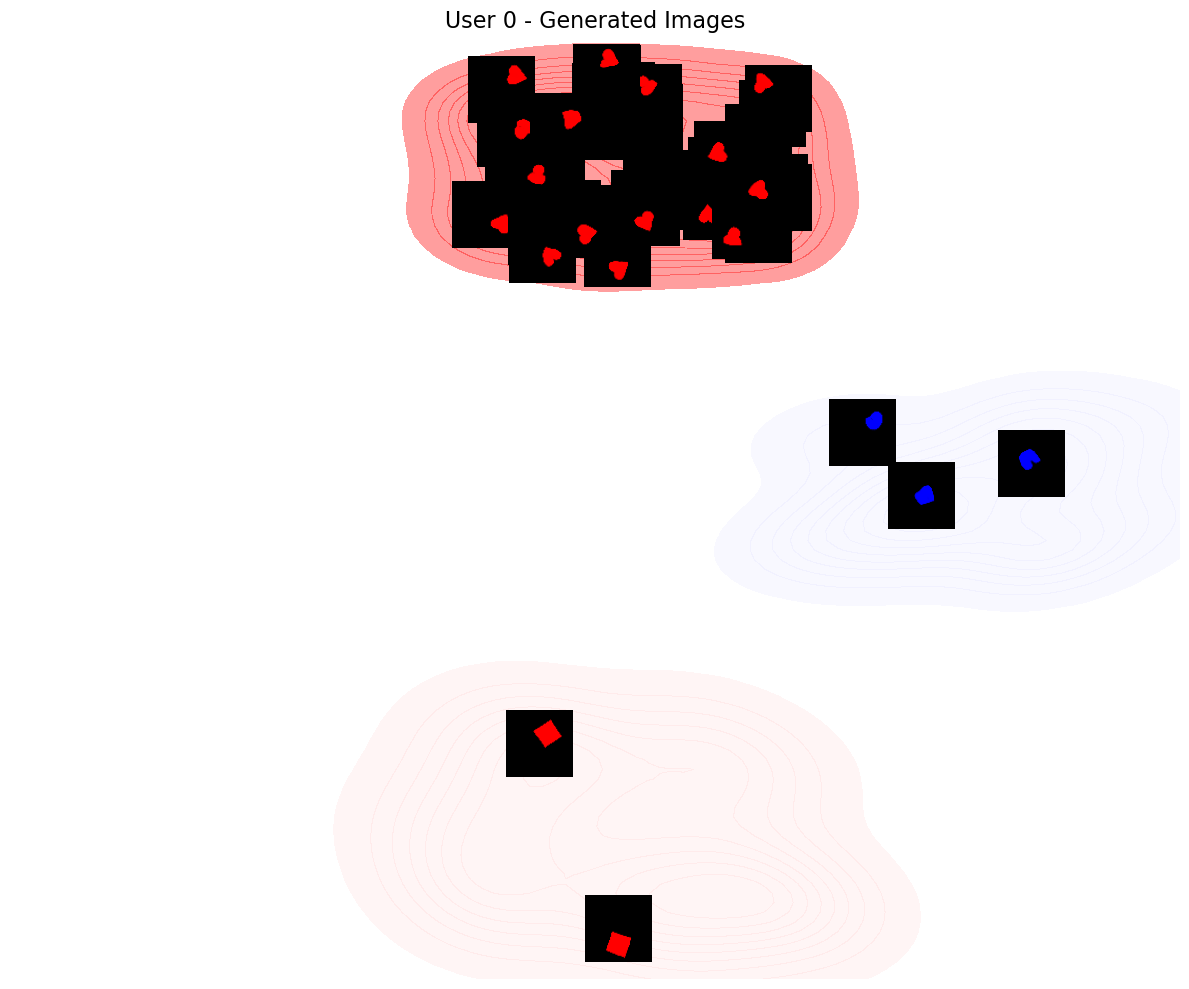

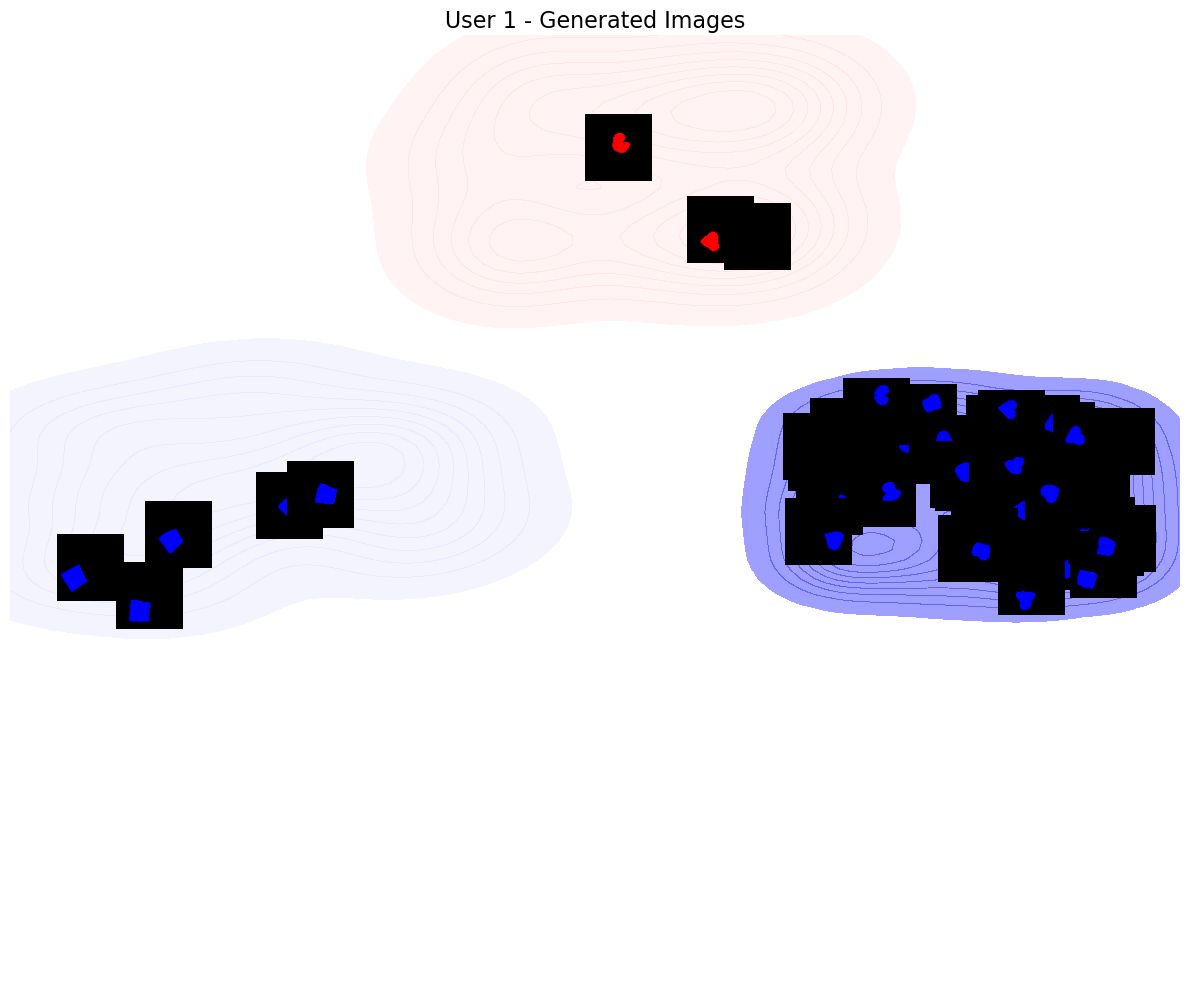

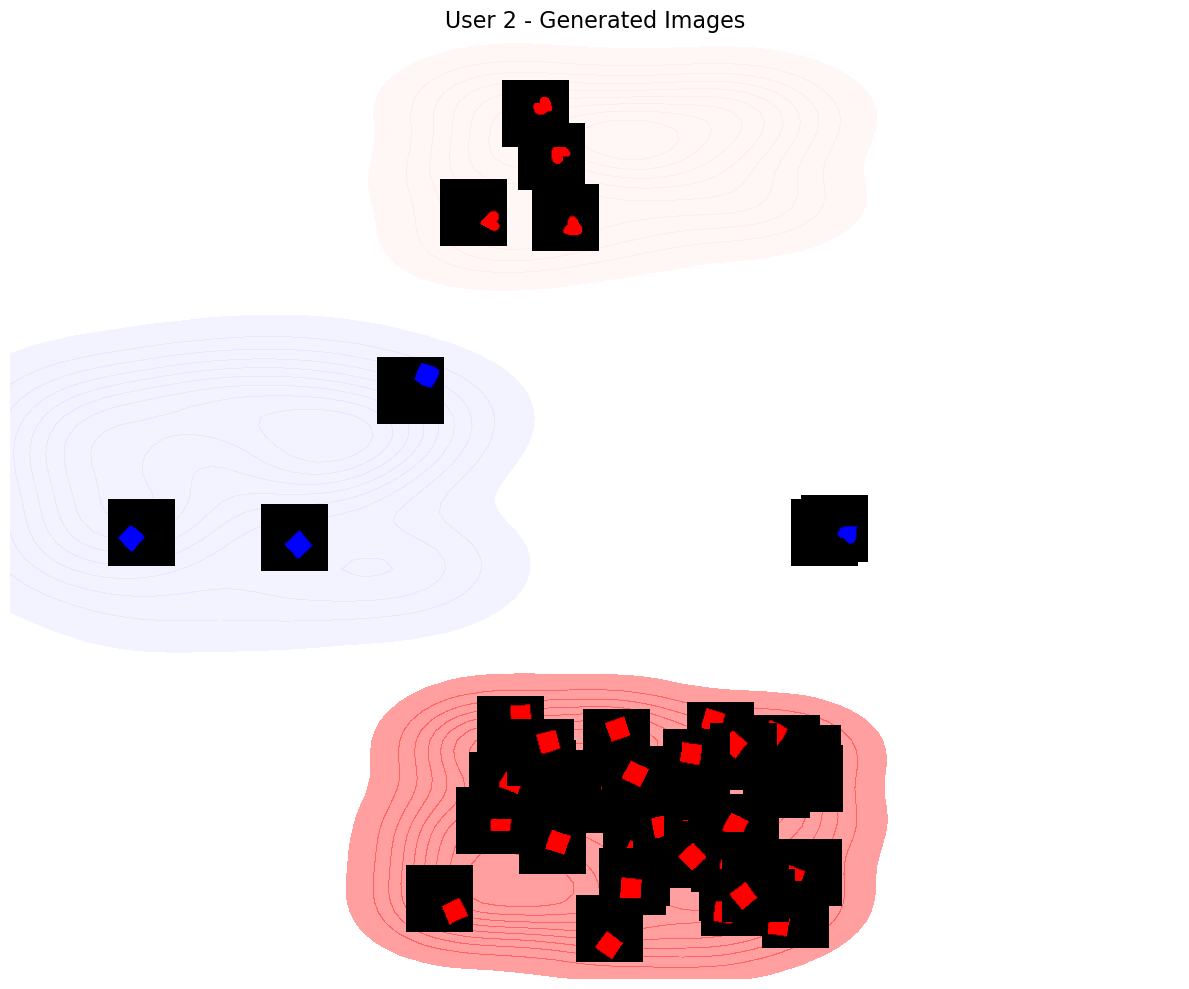

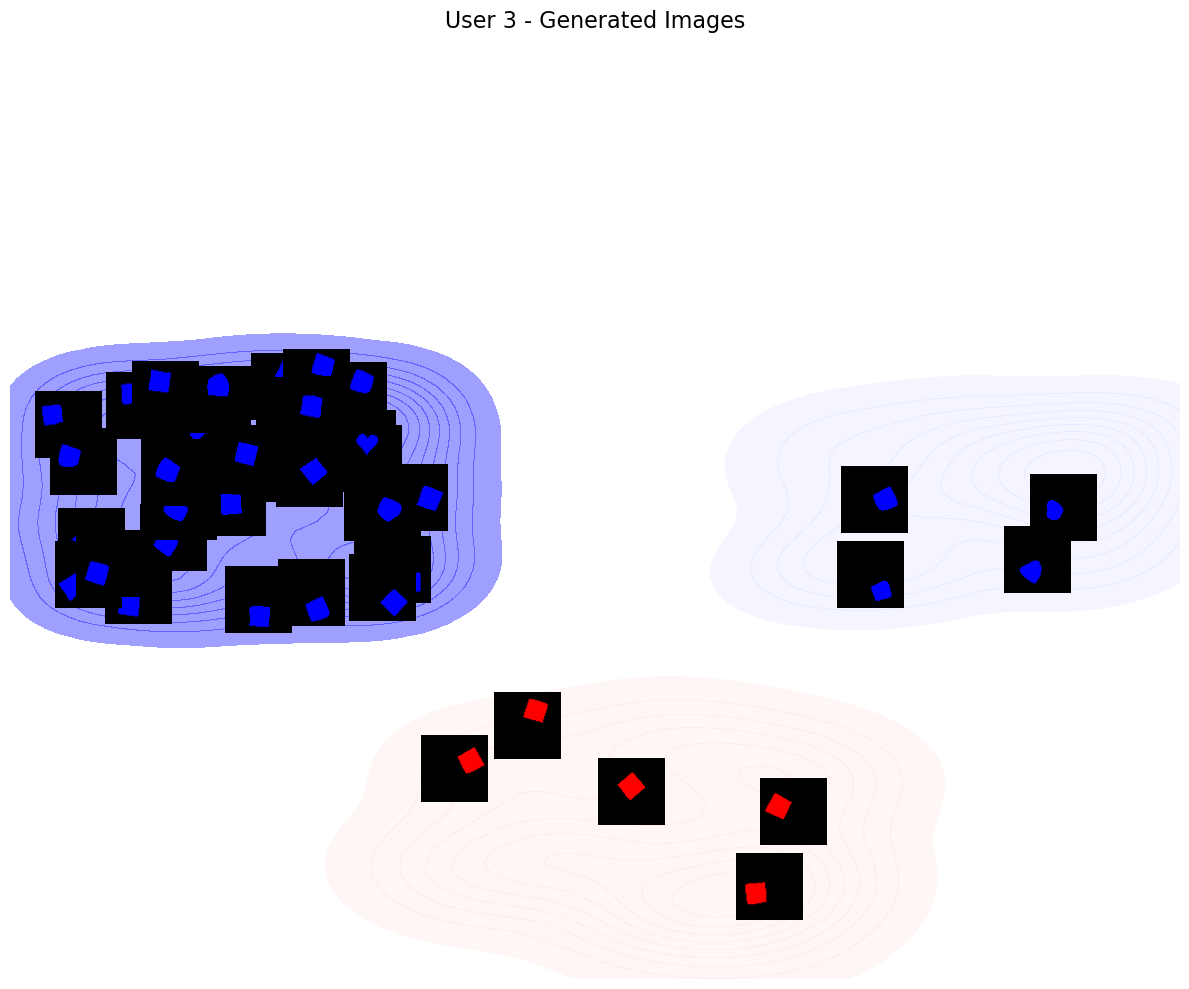

In [24]:
rebeca_prior.eval()
for user_id in [0, 1, 2, 3]:
    with torch.no_grad():
        embs = sample_latents_from_prior(
            model=rebeca_prior,
            noise_scheduler=noise_scheduler,
            user_id=user_id,
            score=1,
            latent_dim=16,
            num_samples=45,
            device=device
        )
    
    projected_coords = umap_model.transform(embs.detach().cpu().numpy())
    rebeca_decoded = autoencoder_ld16_model.decode(embs).detach().cpu().numpy()
    rebeca_user_images = np.transpose(rebeca_decoded, (0, 2, 3, 1))
    rebeca_user_images = np.clip(rebeca_user_images, 0.0, 1.0)
    plot_combined_kde_and_images(
    latent_np=X_umap,
    shapes=shapes,
    colors=colors,
    R=R.numpy(),
    user_idx=user_id,  # or any user ID
    generated_coords=projected_coords,
    decoded_images=rebeca_user_images,
    zoom=0.75,
    figsize=(12, 10),
    save_path=f"../figures/kde_decoded_user_{user_id}.pdf"  # Optional
)

